In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The content is inspired by one of the assignments provided by Dr Brian Jackel at the University of Calgary: Physics and Astronomy http://contacts.ucalgary.ca/info/phas/profiles/486-146343

# In depth investigation of Atmospheric Carbon Dioxide Data.

This notebook makes a prediction of the CO2 level in distant future (year <2300) and assess the threat level we face. The data is available to the public at https://datahub.io/core/co2-ppm.

## Understanding the Data - Summary

Printing the first 10 rows of data

In [28]:
data=pd.read_csv("co2-mm-mlo_csv.csv",sep=',')
data[:10]

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1
5,1958-08-01,1958.625,314.93,314.93,315.94,-1
6,1958-09-01,1958.708,313.20,313.20,315.91,-1
7,1958-10-01,1958.792,-99.99,312.66,315.61,-1
8,1958-11-01,1958.875,313.33,313.33,315.31,-1
9,1958-12-01,1958.958,314.67,314.67,315.61,-1


Decimal Date= Date decimal form  
Average= Monthly average of the CO2 ppm (has a value of -99.99 for missing data)  
Interpolated= Interpolated Monthly average of the CO2 ppm  
Trend= Trend of the Monthly Average of the CO2 ppm  

In [29]:
# Since the data is small, set up variables for easy access without performance loss.
Date_long=data['Date']
Date=data['Decimal Date']
Interpolated=data['Interpolated']
Trend=data['Trend']
Average=data['Average']

## Plot visualizations

Along with the summary above, a simple visualizzation of the data should always precede pre-processing and DEFINITELY before modelling the data for the simple logic that one is unlikely to get a meaningful result by blind manipulation of the data (a.k.a a consequence to no-free-lunch theorem).

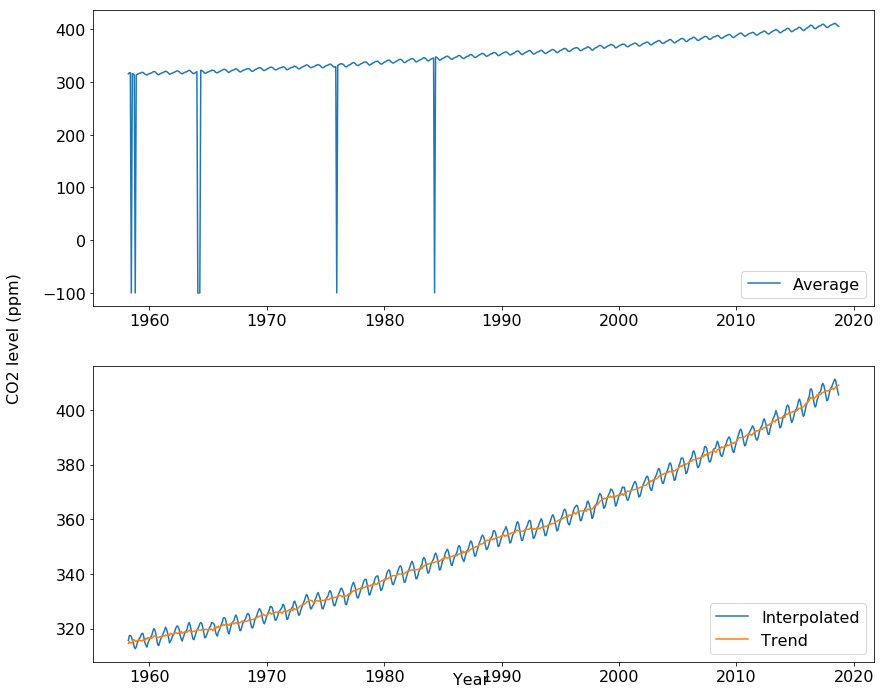

In [30]:
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(2,figsize=[14,12])

ax[0].plot(data["Decimal Date"], data['Average'], label='Average')
ax[1].plot(data['Decimal Date'], data['Interpolated'],label='Interpolated')
ax[1].plot(data['Decimal Date'], data['Trend'],label='Trend')
ax[0].legend(loc=4)
ax[1].legend(loc=4)
fig.text(0.04,0.5,"CO2 level (ppm)", rotation=90, verticalalignment='center')
fig.text(0.5,0.1,"Year", horizontalalignment='center')
plt.show()

## Pre-processing -  Assessment

Here i assess the need for pre-processing.

### Skewness

skewness statistic is defined as:

skewness$=\frac{\sum(x_i-\bar{x})^3}{(n-1)\nu^{2/3}}$ where $, \nu=\frac{\sum (x_i-\bar{x})^{2}}{n-1}$ [from Chapter 3 of Applied Predictive Modeling by Max Kuhn, Kjell Johnson]  


In [31]:
def find_skewness(x,nu):
    assert x.shape
    mean=np.mean(x)
    skewness=np.sum((x-mean)**3)
    return skewness/((x.size-1)*nu**(3/2))
    
def find_nu(x):
    mean=np.mean(x)
    nu=np.sum((x-mean)**2)
    return nu/(x.size-1)

nu=find_nu(Interpolated)
skewness=find_skewness(Interpolated,nu)

print("skewnewss: ",round(skewness,3))

skewnewss:  0.336


### General Statistics

In [32]:
data.describe()

,Decimal Date,Average,Interpolated,Trend,Number of Days
count,727.000000,727.000000,727.000000,727.000000,727.000000
mean,1988.458333,349.555846,353.640702,353.633054,18.341128
std,17.500926,52.068588,27.443136,27.369003,12.242015
min,1958.208000,-99.990000,312.660000,314.620000,-1.000000
25%,1973.333500,328.425000,328.555000,329.295000,-1.000000
50%,1988.458000,351.310000,351.310000,351.370000,24.000000
75%,2003.583500,375.700000,375.700000,376.135000,28.000000
max,2018.708000,411.240000,411.240000,409.020000,31.000000


I see no desperate need of a pre-processing since the values are finite with relatively low standard deviations, low skewness, and the data has already been pre-processed to a good degree from the source

## Decomposition

Based on visualization, it is clear that the Interpolated values can be divided into two componenets: Seasonal component and the Trend.

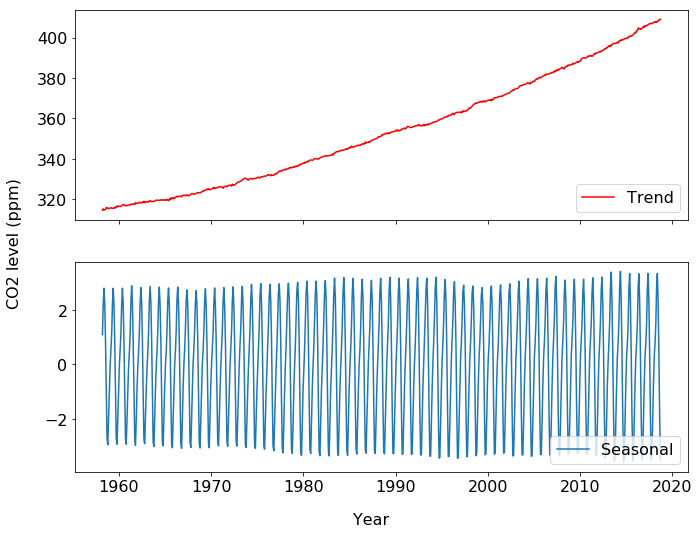

In [33]:
fig,ax=plt.subplots(2, figsize=[11,8.5],sharex=True)

ax[1].plot(Date, Interpolated-Trend, color='C0', label='Seasonal')
ax[0].plot(Date, Trend, color='red', label='Trend')
fig.text(0.04,0.5,"CO2 level (ppm)", rotation=90, verticalalignment='center')
fig.text(0.5,0.04,"Year", horizontalalignment='center')
for i in [0,1]:
    ax[i].legend(loc=4)

# Analysis
I perform two analysis, one for the Trend component and one for the Seasonal
### Analysis: Trend

The Trend data directly provides insights into the CO2's progression and behavior. We can answer common questions like:
1. In which year did it hit 400 ppm average?  
2. Average increase in ppm per year?

#### In which year did it hit 400 ppm?

In [34]:
first_400_ppm=Trend[Trend>400]
print("400 ppm was reached in the year: ",int(Date[first_400_ppm.index.values[0]]))

400 ppm was reached in the year:  2015


#### Average increase in ppm per year?

The growth is accelerating. One way to resolve this is to divide the plot into multiple segments, then apply linear regression to each segments. Let's divide it per 10 years.

Text(0.5, 1.0, 'Increase in CO2 concentration in the atmosphere')

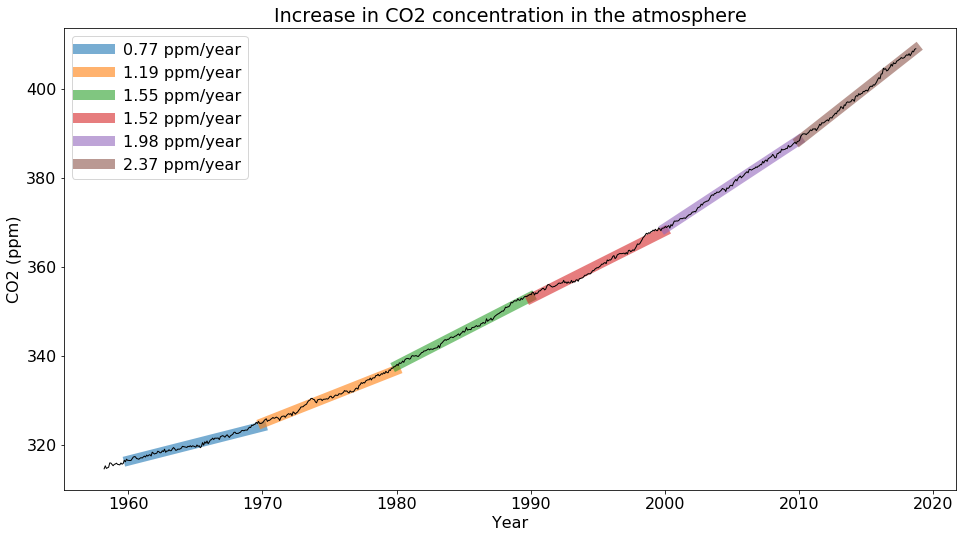

In [35]:
import scipy.optimize
import bisect

fig,ax=plt.subplots(1,figsize=[16,8.5])

def Linear_fit(x,a,b):
    return a*x+b

for i in range(1960,2020,10):
    a=bisect.bisect_left(Date,i)
    b=bisect.bisect_left(Date,i+10)
    
    popt,pcov=scipy.optimize.curve_fit(Linear_fit, Date[a:b], Interpolated[a:b])
    ax.plot(Date[a:b], popt[0]*Date[a:b]+popt[1],linewidth=10,alpha=0.6, label=str(round(popt[0],2))+" ppm/year")
ax.legend()

ax.plot(Date, Trend,alpha=1, linewidth=1,color='black')
ax.set_ylabel("CO2 (ppm)")
ax.set_xlabel("Year")
ax.set_title("Increase in CO2 concentration in the atmosphere")

The acceleration of ppm level is increasing over the year

### Analysis: Seasonal

In a typical time series, I am required to perform various tasks, one of them being investigating the frequency's behavior over time. However the time series we are dealing with is year and we have a reason to speculate that the frequency of the oscillations is invariant over time with its associated wavelength being 1 Year. Let's visualize:

(1958.2079999999999, 2018.7079999999999)

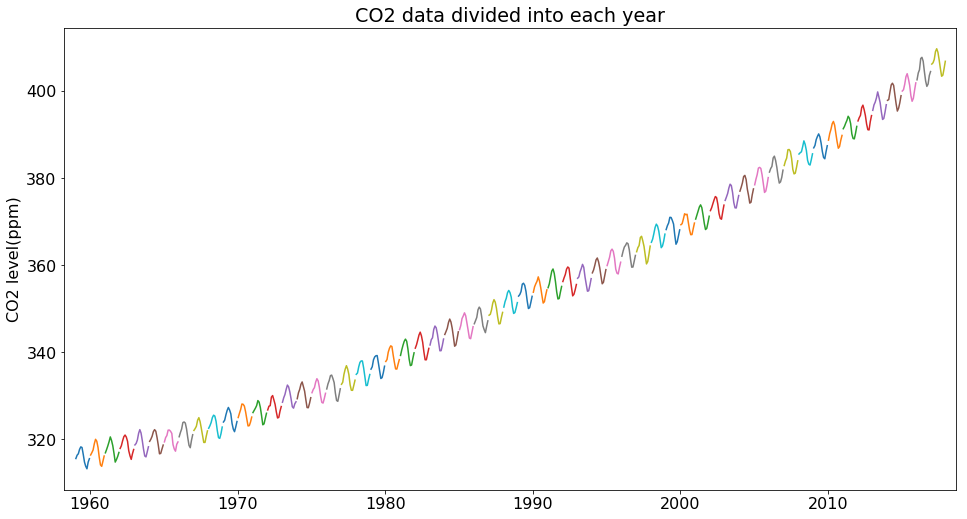

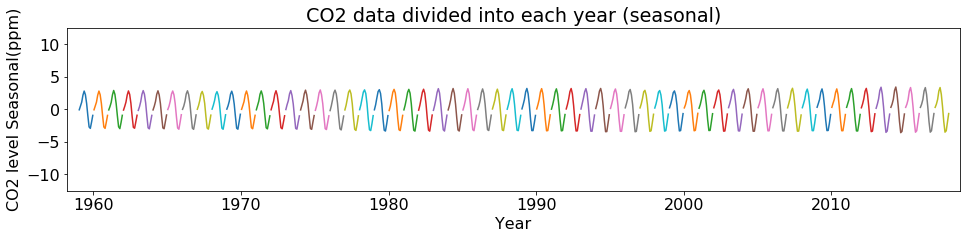

In [36]:
# Getmonths of each data
Date_long_month=np.array([i.split('-')[1] for i in Date_long])
Date_long_Jan=np.where(Date_long_month=='01')[0]
Date_long_Dec=np.where(Date_long_month=='12')[0]

fig,ax0=plt.subplots(1, figsize=[16,8.5])
fig,ax1=plt.subplots(1, figsize=[16,3])

Seasonal= Interpolated-Trend
for e,(i,j) in enumerate(zip(Date_long_Jan, Date_long_Dec[1:])):
    # top plot
    ax0.plot(Date[i:j+1],Interpolated[i:j+1])
    ax1.plot(Date[i:j+1],Seasonal[i:j+1])
    
ax0.set_title("CO2 data divided into each year")
ax1.set_title("CO2 data divided into each year (seasonal)")
ax1.set_ylabel("CO2 level Seasonal(ppm)")
ax0.set_ylabel("CO2 level(ppm)")
ax1.set_xlabel("Year")
ax1.set_ylim(-12.5,12.5)
ax0.set_xlim(Date.iloc[0],Date.iloc[-1])
ax1.set_xlim(Date.iloc[0],Date.iloc[-1])

#plt.show()


As suspected, the frequency of the wave is invariant, and its frequency is 1 year. Now instead of visualizing it as a time series, we compare the similarity between each waves independent of the year.

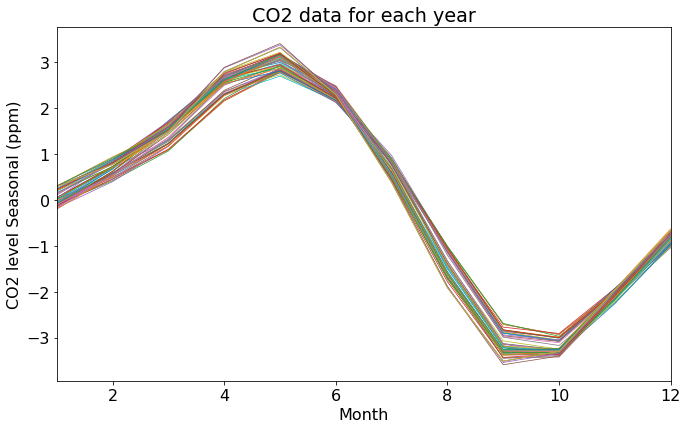

In [37]:
fig,ax=plt.subplots(1, figsize=[11,6.5])

Seasonal= Interpolated-Trend
for e,(i,j) in enumerate(zip(Date_long_Jan, Date_long_Dec[1:])):
    # top plot
    ax.plot(np.arange(1,13),Seasonal[i:j+1],linewidth=0.75)
    
ax.set_title("CO2 data for each year")
ax.set_ylabel("CO2 level Seasonal (ppm)")
ax.set_xlabel("Month")
ax.set_xlim([1,12])
plt.show()

While this shows the similarity between each year's CO2 behavior, it's better to employ statistical measures

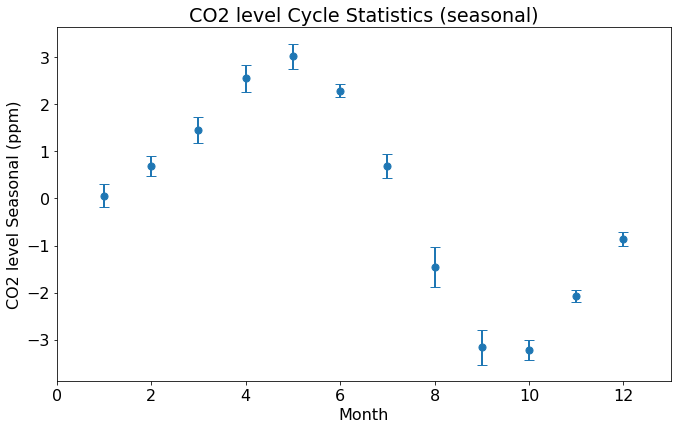

In [38]:
fig,ax=plt.subplots(1, figsize=[11,6.5],sharey=True, sharex=True)

Seasonal= Interpolated-Trend
for i in range(1,13):
    string_month=str(i)
    if len(string_month)<2:
        string_month="0"+string_month
    msk=Date_long_month==str(string_month)
    
    mean=np.mean(Seasonal[msk])
    std=np.std(Seasonal[msk])
    #median=np.median(Seasonal[msk])
    #q25,q75=np.percentile(Seasonal[msk],[25,75])
    #iqr=q75-q25
    
    ax.errorbar(i,mean,yerr=std*1.5,elinewidth=2, barsabove=True,capsize=5,color='C0',zorder=1)
    ax.scatter(i,mean,s=50,color='C0',zorder=2)
    
ax.set_title("CO2 level Cycle Statistics (seasonal)")
ax.set_ylabel("CO2 level Seasonal (ppm)")
ax.set_xlabel("Month")
ax.set_xlim([0,13])
plt.show()

Each point represents the mean CO2 level of each month while the error bars represent 1.5 standard deviations. Higher standard deviations is observed in the months August and September, accompanied by the high gradient of CO2 level vs Month. This confirms that in the entire data set, the seasonal behavior is cyclic with a wavelength of 1 year. The wavelength is invariant over time.

## Prediction

Using regression, I will fit a function $f(x) ,x\in \mathbb{R}$ that will allow me to predict the CO2 level in the future.

No free Lunch theorem (two optimization algorithms are equivalent when their performance is averaged across all possible problems) reminds us that one must carefully examine the problem at hand before applying regression algorithms. So far we've discovered that the trend is non linear and that there is a static (frequency invariant) oscillatory component.


## Curve Fit
### Linear Fit


In [39]:
def chi_square(O,E):
    """Computes chi square
    args:
        O(ndarray) : observed
        E(ndarray) : Expected"""
    return np.sum((O-E)/E)

def poly(x,coeff):
    """Computes a polynomial of the form p0 + p1*x + p2*x^2 + ... upto n degree polynomial where [p0,p1, ...] are provided
    args:
        x(ndarray): input values
        coeff(ndarray or a list): polynomial coefficients)"""
    y=np.ones(x.shape)*coeff[-1]
    for e,p in enumerate(coeff):
        if e!=len(coeff)-1:
            y+=p*x**(len(coeff)-e-1)
    return y

Chi squared:  0.06179516384500916


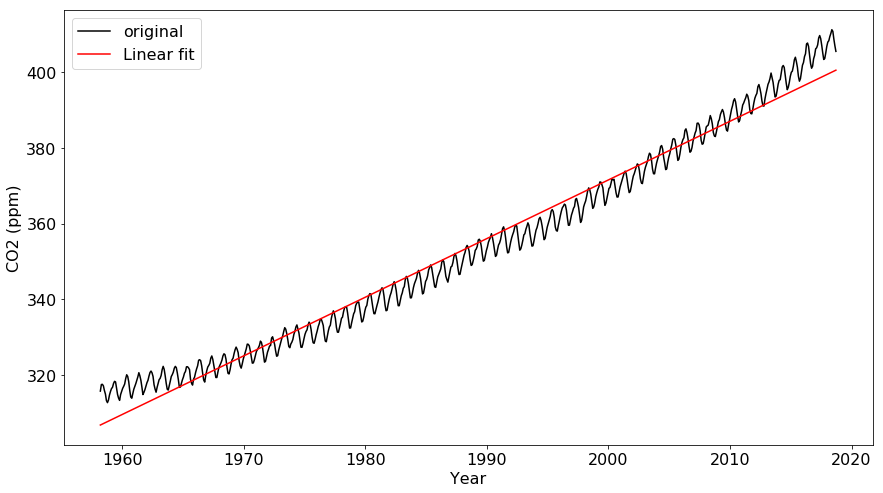

In [40]:
# polynomial fit
x=data['Decimal Date']
y=data['Interpolated']
coeff=np.polyfit(x, y ,1)
yfit=poly(x,coeff)

# plot

plt.figure(figsize=(14.5,8))
plt.plot(x, y, color='black', label='original')
plt.plot(x, yfit, color='red', label='Linear fit')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.legend()
print('Chi squared: ',chi_square(poly(x,coeff),y))
plt.show()

### Polynomial Fit

Chi squared:  0.027211704394405824


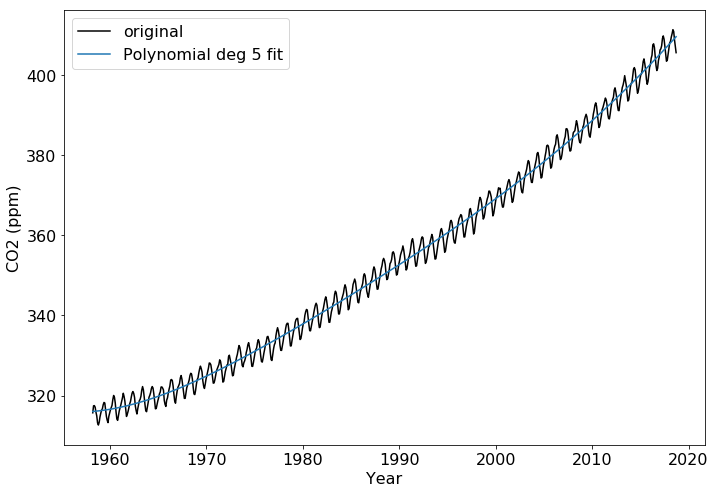

In [41]:
x=data['Decimal Date']
y=data['Interpolated']
coeff=np.polyfit(x,y,5)
yfit=poly(x,coeff)

plt.figure(figsize=[11.5,8])
plt.plot(x, y, color='black', label='original')
plt.plot(x, yfit, color='C0', label='Polynomial deg 5 fit')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Year')
plt.legend()
print('Chi squared: ',chi_square(poly(x,coeff),y))
plt.show()


Polynomial fit improved the chi square by 2-fold. Both visually and statistically, it gives better performance than linear regression.

## Capturing Seasonality:

Both Linear fit and polynomial fit only captures the trend component of the data. The seasonality is yet to be captured. One practical way to fit the seasonality is through Fourier series. The Fourier series is defined as:

$F(x)=a_0 + \sum_{i=1}^{n} a_i cos(\frac{2\pi x}{T}) + b_i sin(\frac{2\pi x}{T})$

## Fourier Series
To use scipy.optimize.curve_fit, the function must be structured such that its arguments can be passed to the curve_fit function
directly. This causes a bit of a problem when it comes to synthesizing fourier series because it is heavily iterative. Therefore I solve this problem by printing out the code and then copy and pasting it as a code.

In [42]:
def fourier_series_synthesizer(n,T):
    print_coeff=""
    print_string=""
    for i in range(1,n):
        print_coeff+=", a_"+str(i)+", b_"+str(i)
        print_string+=" a_"+str(i)+"*np.cos(np.pi*"+ str(i/T) +"*x) +" + " b_"+str(i)+"*np.sin(np.pi*"+str(i/T)+"*x) +"
    
    print("a_0"+print_coeff)
    print(" ")
    print("a_0 +"+print_string)
    
fourier_series_synthesizer(20,4)

a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19
 
a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) 

In [43]:
def fourier_series(x, a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19):
    
    return a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) + b_15*np.sin(np.pi*3.75*x) + a_16*np.cos(np.pi*4.0*x) + b_16*np.sin(np.pi*4.0*x) + a_17*np.cos(np.pi*4.25*x) + b_17*np.sin(np.pi*4.25*x) + a_18*np.cos(np.pi*4.5*x) + b_18*np.sin(np.pi*4.5*x) + a_19*np.cos(np.pi*4.75*x) + b_19*np.sin(np.pi*4.75*x)

Now curve_fit function can be used

In [44]:
import scipy.optimize

x=data['Decimal Date']
y=data['Interpolated']

popt,pcov=scipy.optimize.curve_fit(fourier_series, x, y)
popt

array([ 3.53599250e+02,  3.33696030e-01,  9.34776184e-01, -1.32168615e+00,
        1.20775368e+00,  6.58145052e-01, -5.53561680e-01,  6.31944395e-01,
        8.72088567e-02, -7.15722638e-01, -1.02759584e-01, -2.32326183e-04,
       -1.68218198e-01,  3.21384361e-01,  4.77776235e-01, -1.12888198e+00,
        2.52634891e+00,  7.92382131e-02, -3.67535694e-01, -7.51472973e-02,
        2.65139814e-01, -1.78754384e-01,  8.29517183e-02,  2.88533203e-01,
       -1.23860950e-01,  5.27088139e-02,  2.52604767e-02, -2.57120760e-01,
       -1.00940023e-01,  1.05274648e-01, -1.52405249e-03,  7.48153329e-01,
       -2.27033142e-01, -5.23961702e-02, -1.84921309e-01,  7.04320368e-02,
       -1.25034549e-01, -9.30283686e-02,  1.99810977e-01])

Text(0.5, 0.04, 'Year')

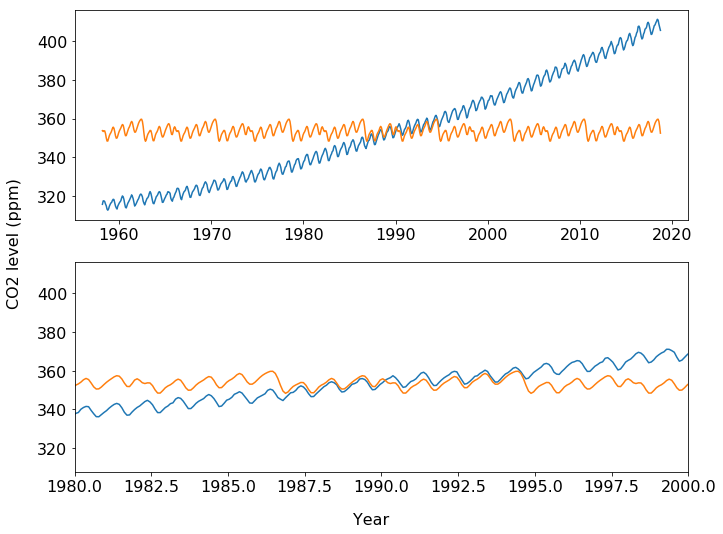

In [45]:
fig,ax=plt.subplots(2,figsize=[11,8.5])
ax[0].plot(x,y, label='original')
ax[0].plot(x, fourier_series(x,*popt),label='fourier fit')
ax[1].plot(x,y,label='original')
ax[1].plot(x, fourier_series(x,*popt),label='fourier fit')
ax[1].set_xlim([1980,2000])

fig.text(0.04,0.5,"CO2 level (ppm)", rotation=90, verticalalignment='center')
fig.text(0.5,0.04,"Year", horizontalalignment='center')

This time we have captured the seasonality, however it did not capture the trend. 

## Polynomial fit + fourier series fit

So the polynomial fit cannot capture the seasonality, and the fourier series cannot capture the trend (In theory it can, but it is not always practical). The obvious solution here is to combine the two. And to avoid over-fitting, polynomial of degree greater than 3 were omitted.

In [46]:
def fourier_series(x, p1 , p2 , p3 , a_0, a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, a_5, b_5, a_6, b_6, a_7, b_7, a_8, b_8, a_9, b_9, a_10, b_10, a_11, b_11, a_12, b_12, a_13, b_13, a_14, b_14, a_15, b_15, a_16, b_16, a_17, b_17, a_18, b_18, a_19, b_19):
    
    return p1*x + p2*x**2 + p3*x**3  + a_0 + a_1*np.cos(np.pi*0.25*x) + b_1*np.sin(np.pi*0.25*x) + a_2*np.cos(np.pi*0.5*x) + b_2*np.sin(np.pi*0.5*x) + a_3*np.cos(np.pi*0.75*x) + b_3*np.sin(np.pi*0.75*x) + a_4*np.cos(np.pi*1.0*x) + b_4*np.sin(np.pi*1.0*x) + a_5*np.cos(np.pi*1.25*x) + b_5*np.sin(np.pi*1.25*x) + a_6*np.cos(np.pi*1.5*x) + b_6*np.sin(np.pi*1.5*x) + a_7*np.cos(np.pi*1.75*x) + b_7*np.sin(np.pi*1.75*x) + a_8*np.cos(np.pi*2.0*x) + b_8*np.sin(np.pi*2.0*x) + a_9*np.cos(np.pi*2.25*x) + b_9*np.sin(np.pi*2.25*x) + a_10*np.cos(np.pi*2.5*x) + b_10*np.sin(np.pi*2.5*x) + a_11*np.cos(np.pi*2.75*x) + b_11*np.sin(np.pi*2.75*x) + a_12*np.cos(np.pi*3.0*x) + b_12*np.sin(np.pi*3.0*x) + a_13*np.cos(np.pi*3.25*x) + b_13*np.sin(np.pi*3.25*x) + a_14*np.cos(np.pi*3.5*x) + b_14*np.sin(np.pi*3.5*x) + a_15*np.cos(np.pi*3.75*x) + b_15*np.sin(np.pi*3.75*x) + a_16*np.cos(np.pi*4.0*x) + b_16*np.sin(np.pi*4.0*x) + a_17*np.cos(np.pi*4.25*x) + b_17*np.sin(np.pi*4.25*x) + a_18*np.cos(np.pi*4.5*x) + b_18*np.sin(np.pi*4.5*x) + a_19*np.cos(np.pi*4.75*x) + b_19*np.sin(np.pi*4.75*x)

In [47]:
import scipy.optimize

x=data['Decimal Date']
y=data['Interpolated']

popt,pcov=scipy.optimize.curve_fit(fourier_series, x, y)
popt

array([ 1.27512612e+02, -7.59636437e-02,  1.48484758e-05, -6.95891737e+04,
        6.91009107e-02, -1.36918287e-01, -2.68543794e-02, -1.72891926e-02,
       -9.84892205e-03, -1.03607598e-02,  2.04613285e-02,  3.10656167e-02,
        5.04090072e-03,  1.31796372e-02,  4.05315883e-02, -9.08410069e-03,
       -6.02961205e-03,  1.03818894e-02, -1.01576803e+00,  2.63808256e+00,
        3.73845243e-03,  1.72768953e-02,  9.14254824e-04, -8.38448897e-04,
        8.09940873e-03, -2.14545797e-02,  3.66729368e-03,  1.56111879e-02,
        9.16337325e-03, -2.50062022e-02,  1.75383103e-02, -2.43578912e-03,
        8.58881370e-03, -2.51679955e-02,  6.58781649e-01, -4.28201373e-01,
        4.15733694e-03, -1.53279875e-02,  1.44742062e-02, -1.54312147e-02,
        1.16971567e-02,  1.30691917e-02])

Chi square:  0.0002021388028842913


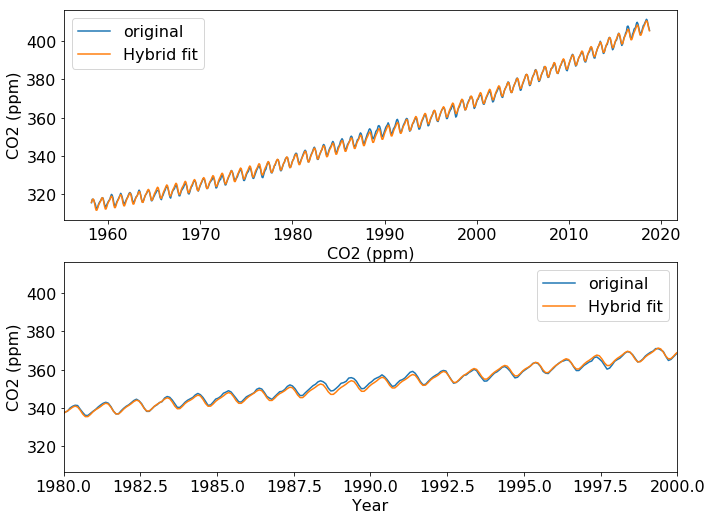

In [50]:
fig,ax=plt.subplots(2,figsize=[11,8.5])
ax[0].plot(x,y,label='original')
ax[0].plot(x, fourier_series(x,*popt),label='Hybrid fit')
ax[0].set_xlabel("CO2 (ppm)")
ax[1].plot(x,y,label='original')
ax[1].plot(x, fourier_series(x,*popt),label='Hybrid fit')
ax[0].set_ylabel("CO2 (ppm)")
ax[1].set_ylabel("CO2 (ppm)")
ax[1].set_xlim([1980,2000])
ax[1].set_xlabel("Year")
for i in [0,1]:
    ax[i].legend()
print("Chi square: ",chi_square(y,fourier_series(x,*popt)))

## Prediction

I have the fitted function, validated by the chi square test. Let's see what the CO2 level would be like in the future

Text(0.5, 0, 'Year')

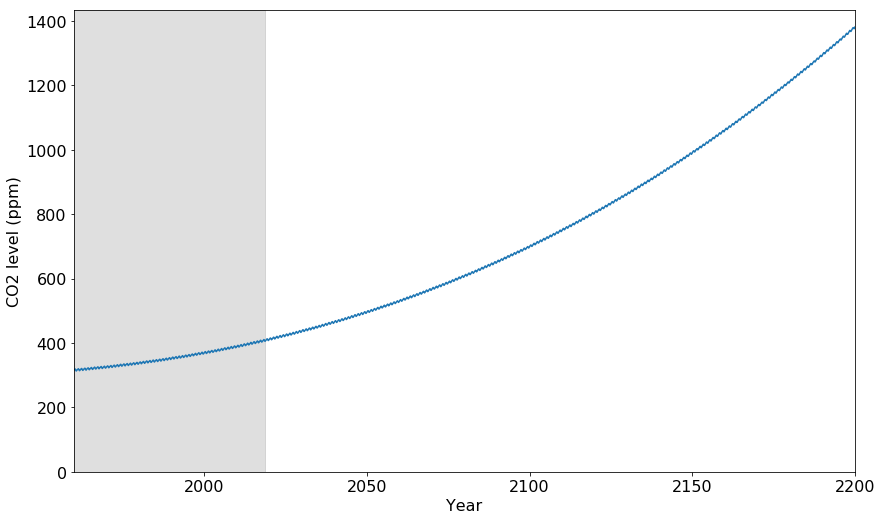

In [49]:
fig,ax=plt.subplots(1, figsize=[14,8.5])
ax.plot(np.linspace(1960,2200,12*260), fourier_series(np.linspace(1960,2200,12*260),*popt))

ax.axvspan(  data['Decimal Date'].iloc[0], data['Decimal Date'].iloc[-1]  ,color='gray',alpha=0.25)
ax.set_xlim(1960,2200)
ax.set_ylim(bottom=0)
ax.set_ylabel("CO2 level (ppm)")
ax.set_xlabel("Year")

Despite not using high degree polynomial, the graph is still considered over-fitted, hence the predicton must be looked at with skepticism. We can try fitting in more functions to improve, but the question at hand is: will they improve the analysis?

## Discussion

As stated above, the prediction results should be looked at with skepticism. We can try fitting in other functions to improve the fit for the sake of fitting, but without proper domain knowledge, no-free-lunch theorem tells us that the results would have no meanings, and that the result would be just as good as the hybrid fit above. To continue, we must incorporate proper-domain knowledge. It requires knowledge of the CO2 emission sources, and each sources' prospect over the coming years, possibility of non-CO2 emission energy source, and more, which is more than what I am trying to accomplish, at least for now. So

# Incorporating the domain knowledge

So far all the works I've done is as a bad data scientist. Bad data scientist LOVES writing codes, fancy algorithms, boast about their programming knowledge, however they often lack or ignore the domain knowledge that is specific to the data.

The above works are of the bad data scientist